In [1]:

print(__doc__)

import numpy as np

import matplotlib.pyplot as plt

from keras.models import load_model

import params
import gpflow

def rescale01(xmin, xmax, f):
    return (f - xmin) / (xmax - xmin)

import time
import pickle
import os
from sklearn.decomposition import PCA
import gpflow
import scipy.signal

# import matplotlib.ticker as ticker
# from itertools import cycle
# import matplotlib.ticker as ticker
# from pathlib import Path
# from matplotlib import gridspec

import SetPub
SetPub.set_pub()

import params

from keras.models import load_model
from keras import backend as K



Automatically created module for IPython interactive environment


Using TensorFlow backend.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:

###################### PARAMETERS ##############################

original_dim = params.original_dim # 2549
intermediate_dim2 = params.intermediate_dim2 # 1024
intermediate_dim1 = params.intermediate_dim1 # 512
intermediate_dim = params.intermediate_dim # 256
latent_dim = params.latent_dim # 10

ClID = params.ClID
num_train = params.num_train # 512
num_test = params.num_test # 32
num_para = params.num_para # 5

batch_size = params.batch_size # 8
num_epochs = params.num_epochs # 100
epsilon_mean = params.epsilon_mean # 1.0
epsilon_std = params.epsilon_std # 1.0
learning_rate = params.learning_rate # 1e-3
decay_rate = params.decay_rate # 0.0

noise_factor = params.noise_factor # 0.00

######################## I/O ##################################

DataDir = params.DataDir
PlotsDir = params.PlotsDir
ModelDir = params.ModelDir

fileOut = params.fileOut

In [3]:

# ----------------------------- i/o ------------------------------------------


Trainfiles = np.loadtxt(DataDir + 'P'+str(num_para)+ClID+'Cl_'+str(num_train)+'.txt')
Testfiles = np.loadtxt(DataDir + 'P'+str(num_para)+ClID+'Cl_'+str(num_test)+'.txt')

Cl_Original = (Testfiles[:, num_para+2:])  # [2:3]


para_train = Trainfiles[:, 0: num_para]
para_test =  Testfiles[:, 0: num_para]

print(para_train.shape, 'train sequences')
print(para_test.shape, 'test sequences')


ls = np.loadtxt( DataDir + 'P'+str(num_para)+'ls_'+str(num_train)+'.txt')[2:]


normFactor = np.loadtxt(DataDir+'normfactorP'+str(num_para)+ClID+'_'+ fileOut +'.txt')
meanFactor = np.loadtxt(DataDir+'meanfactorP'+str(num_para)+ClID+'_'+ fileOut +'.txt')

print('-------normalization factor:', normFactor)
print('-------rescaling factor:', meanFactor)




(1024, 5) train sequences
(25, 5) test sequences
-------normalization factor: 11367.03490651889
-------rescaling factor: 0.0


In [4]:
fileOut

'P5Model_tot1024_batch8_lr0.0001_decay1.0_z32_epoch7500'

In [4]:
################# ARCHITECTURE ###############################

LoadModel = True
if LoadModel:

    # fileOut = 'VanillaModel_tot'+str(num_train)+'_batch'+str(batch_size)+'_lr'+str( learning_rate)+'_decay'+str(decay_rate)+'_z'+str(latent_dim)+'_epoch'+str(num_epochs)

    # vae = load_model(ModelDir + 'fullAE_' + fileOut + '.hdf5')
    encoder = load_model(ModelDir + 'EncoderP'+str(num_para)+ClID+'_' + fileOut + '.hdf5')
    decoder = load_model(ModelDir + 'DecoderP'+str(num_para)+ClID+'_' + fileOut + '.hdf5')
    history = np.loadtxt(ModelDir + 'TrainingHistoryP'+str(num_para)+ClID+'_'+fileOut+'.txt')


# # ------------------------------------------------------------------------------


# # ------------------------------------------------------------------------------
encoded_xtrain = np.loadtxt(DataDir + 'encoded_xtrainP'+str(num_para)+ClID+'_'+ fileOut +'.txt')
encoded_xtest = np.loadtxt(DataDir+'encoded_xtestP'+str(num_para)+ClID+'_'+ fileOut +'.txt')


# ------------------------------------------------------------------------------
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
# ------------------------------------------------------------------------------


max_relError = 0
ErrTh = 1.0
PlotRatio = True
IfVariance = False # Computation is a lot slower with Variance


W_predArray = np.zeros(shape=(num_test,latent_dim))
W_varArray = np.zeros(shape=(num_test,latent_dim))

x_decoded = np.zeros(shape=(num_test,original_dim))
x_decodedmax = np.zeros(shape=(num_test,original_dim))
x_decodedmin = np.zeros(shape=(num_test,original_dim))


/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:



if PlotRatio:

    # W_pred = np.array([np.zeros(shape=latent_dim)])
    # W_pred_var = np.array([np.zeros(shape=latent_dim)])


    # kern = GPy.kern.Matern52(input_dim= num_para)
#     kern = GPy.kern.Matern52(5, 0.1)


    if (IfVariance == False):

        #########################################################################################
        ## All GP fitting together -- works fine, except we get one value of variance for all
        # output dimensions, since they're considered independent


#         m1 = GPy.models.GPRegression(para_train, encoded_xtrain, kernel=kern)
#         m1.Gaussian_noise.variance.constrain_fixed(1e-16)
#         m1.optimize(messages=True)
#         GPmodelOutfile = DataDir + 'GPy_model'+ str(latent_dim)+ClID + fileOut
#         m1.save_model( GPmodelOutfile, compress=True, save_data=True)


#         m1 = GPy.models.GPRegression.load_model(GPmodelOutfile + '.zip')
        
        
        
        kern = gpflow.kernels.Matern52(input_dim = np.shape(para_train)[1], ARD=True)
        m1 = gpflow.models.GPR(para_train, encoded_xtrain, kern=kern, mean_function=None)
        m1.likelihood.variance.assign(1e-20)
#         m1.kern.lengthscales.assign([ 3, 24,  4,  4, 7])
        m1.kern.lengthscales.assign([0.1, 0.1, 0.1, 0.1, 0.1])

        opt = gpflow.train.ScipyOptimizer()
        opt.minimize(m1)
        m1.as_pandas_table()

    
    


#         m1p = m1.predict(para_test)  # [0] is the mean and [1] the predictive
        m1p = m1.predict_f(para_test) 
        W_predArray = m1p[0]
        W_varArray = m1p[1]


        np.savetxt(DataDir + 'WPredArray_GPflowNoVariance'+ str(latent_dim)+ClID + '.txt', W_predArray)

        #########################################################################################

        np.savetxt(DataDir + 'WPredArray_GPy'+ str(latent_dim) +ClID+'.txt', W_predArray)
        np.savetxt(DataDir + 'WvarArray_GPy'+ str(latent_dim) +ClID+ '.txt', W_varArray)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -191323.161238
  Number of iterations: 19
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -191323.161238
  Number of iterations: 19
  Number of functions evaluations: 24


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


0 ERR min max: [-0.004485  0.002055]
1 ERR min max: [-0.003432  0.006455]
2 ERR min max: [-0.004402  0.004267]
3 ERR min max: [-0.025255  0.002266]
4 ERR min max: [-0.012791  0.006374]
5 ERR min max: [-0.006075  0.001205]
6 ERR min max: [-0.021204  0.004065]
7 ERR min max: [-0.017202  0.004063]
8 ERR min max: [-0.004482  0.007702]
9 ERR min max: [-0.004166  0.004257]
10 ERR min max: [-0.004811  0.012268]
11 ERR min max: [-0.009183  0.002500]
12 ERR min max: [-0.006221  0.013741]
13 ERR min max: [-0.002039  0.003734]
14 ERR min max: [-0.002741  0.001827]
15 ERR min max: [-0.007429  0.005817]
16 ERR min max: [-0.003014  0.003712]
17 ERR min max: [-0.002046  0.006718]
18 ERR min max: [-0.007105  0.014392]
19 ERR min max: [-0.003256  0.006028]
20 ERR min max: [-0.009310  0.000748]
21 ERR min max: [-0.024032  0.006997]
22 ERR min max: [-0.006571  0.004250]
23 ERR min max: [-0.003026  0.005710]
24 ERR min max: [-0.004269  0.006977]


/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


--------------------------------------------------
file: P5Model_tot1024_batch8_lr0.0001_decay1.0_z32_epoch7500
##################################################
P5Model_tot1024_batch8_lr0.0001_decay1.0_z32_epoch7500
train loss:  732.4320378303528
test loss:  734.007822265625
max rel error: 2.525521627741134 percent
##################################################


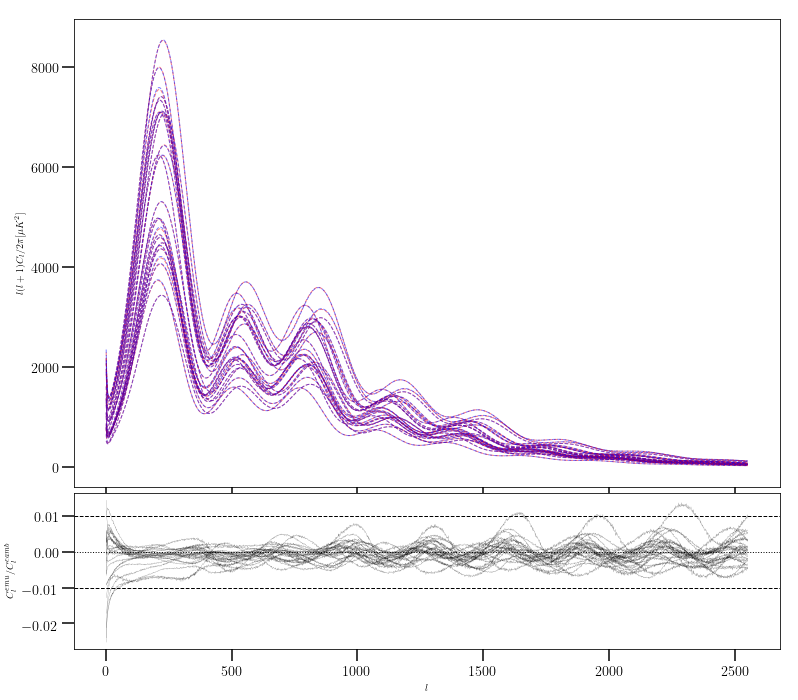

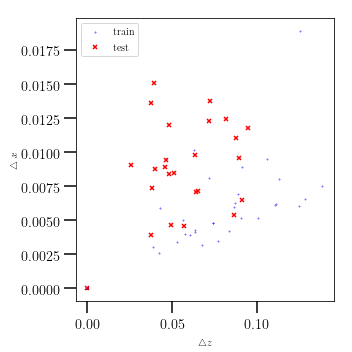

In [8]:


plt.figure(992, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom = 0.15)  # set the spacing between axes.
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ax0.set_ylabel(r'$C_l$')
ax0.set_ylabel(r'$l(l+1)C_l/2\pi [\mu K^2]$')

# ax0.set_title( r'$\text{' +fileOut + '}$')

ax1.axhline(y= 0, ls='dotted')
ax1.axhline(y=.01, ls='dashed')
ax1.axhline(y=-0.01, ls='dashed')

ax1.set_xlabel(r'$l$')

ax1.set_ylabel(r'$C_l^{emu} $/$C_l^{camb}$')
# ax1.set_ylim(0.976, 1.024)



# m1 = GPy.models.GPRegression.load_model(GPmodelOutfile + '.zip')


for i in range(para_test.shape[0]):
# for i in range(1):

        m1p = m1.predict_f(para_test[i].reshape(num_para, -1).T)  # [0] is the mean and [1] the predictive
        W_pred = m1p[0]
        x_decoded[i] = decoder.predict(  W_pred.reshape(latent_dim, -1).T   )

        ax0.plot(ls, (normFactor*x_decoded[i]) +meanFactor, 'r--', alpha= 0.5, lw = 1, label = 'emulated')
        ax0.plot(ls, (Cl_Original[i]), 'b--', alpha=0.5, lw = 1,  label = 'camb')

        cl_ratio = ( (normFactor * x_decoded[i]) +meanFactor)/ (Cl_Original[i])
        relError = ((cl_ratio) - 1)

        if (ClID == 'TE'):  # Absolute error instead (since TE gets crosses 0
            relError = ((normFactor * x_decoded[0]) + meanFactor - Cl_Original[i])




        ax0.plot(ls[np.abs(relError) > ErrTh], (normFactor*x_decoded[i] + meanFactor)[np.abs(
            relError) > ErrTh], 'gx', alpha=0.5, label= 'Err >'+str(ErrTh), markersize = '1')


        # ax1.plot(ls, ( (normFactor*x_decoded[i]) +meanFactor)/ (Cl_Original[i]), '-', lw = 0.5,
        #                  label = 'emu/camb')

        ax1.plot(ls, relError, 'k-', lw = 0.25, label = 'emu/camb', alpha = 0.5)


        print(i, 'ERR min max:', np.array([(relError).min(), (relError).max()]) )
        max_relError = np.max( [np.max(np.abs(relError)) , max_relError] )


plt.figure(992)
# plt.tight_layout()
plt.savefig(PlotsDir + 'TestGPy'+str(num_para)+ClID+fileOut+'.png')



print(50*'-')
print('file:', fileOut)
# ------------------------------------------------------------------------------


epochs = history[0, :]
train_loss = history[1, :]
val_loss = history[2, :]

plotLoss = False
if plotLoss:

    plt.figure(867)
    fig, ax = plt.subplots(1,1, sharex= True, figsize = (8,6))
    # fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace= 0.02)
    ax.plot(epochs,train_loss, '-', lw =1.5)
    ax.plot(epochs,val_loss, '-', lw = 1.5)
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    # ax[0].set_ylim([0,1])
    # ax[0].set_title('Loss')
    ax.legend(['train loss','val loss'])
    #plt.text(5.75, 0.15, 'MaxRelError: %d'%np.int(max_relError) , fontsize=15)
    plt.title(fileOut)
    # plt.tight_layout()
    plt.savefig(PlotsDir + 'TrainingLoss_'+fileOut+'_relError'+ str( np.int(max_relError) ) +ClID+'.png')

#plt.show()

print(50*'#')
print(fileOut)
print('train loss: ', train_loss[-1])
print('test loss: ', val_loss[-1])
print
# print('max rel error:', max_relError)
print('max rel error:', 100*max_relError, 'percent')
print(50*'#')




PlotScatter = False
if PlotScatter:
    plt.figure(431)
    import pandas as pd

    AllLabels = [r'$\Omega_m$', r'$\Omega_b$', r'$\sigma_8$', r'$h$', r'$n_s$']


    for ind in np.arange(1, latent_dim+1):
        AllLabels.append(str("z{0}".format(ind)))


    inputArray = np.hstack([encoded_xtrain, encoded_xtrain])
    df = pd.DataFrame(inputArray, columns=AllLabels)
    axes = pd.tools.plotting.scatter_matrix(df, alpha=0.2, color = 'b')



delta_z = np.zeros(shape=para_train.shape[0] )
delta_xtrain = np.zeros(shape=para_train.shape[0] )

for i in range(encoded_xtrain.shape[1]):
    delta_z[i] = np.sqrt( np.mean(   (para_train[0] - para_train[i])**2  )  )
    delta_xtrain[i] = np.sqrt( np.mean(   (encoded_xtrain[0] -  encoded_xtrain[i])**2  )  )

delta_ztest = np.zeros(shape=para_test.shape[0] )
delta_xtest = np.zeros(shape=para_test.shape[0] )

for i in range(encoded_xtest.shape[0]):
    delta_ztest[i] = np.sqrt( np.mean(   (para_test[0] - para_test[i])**2  )  )
    delta_xtest[i] = np.sqrt( np.mean(   (encoded_xtest[0] -  encoded_xtest[i])**2  )  )



plt.figure(143, figsize=((5,5)))
plt.plot(delta_z, delta_xtrain, 'bx', markersize = 1, alpha = 0.5, label = 'train')
plt.plot(delta_ztest, delta_xtest, 'rx', markersize = 4, label = 'test')




plt.xlabel(r'$\bigtriangleup z$')
plt.ylabel(r'$\bigtriangleup$ $x$')

plt.legend()
plt.tight_layout()
plt.savefig(PlotsDir + 'SensitivityP'+str(num_para)+ClID+fileOut+'.png')
plt.show()

In [ ]:
def LoadModels(GPmodelFile, decoderFile):
    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()

    m1 = saver.load(GPmodelFile, context=ctx_for_loading)
    m1.clear()
    m1.compile()
    
    decoder = load_model(decoderFile)
#     decoder.predict( K.placeholder( ( 32, ) ))

    
    return m1, decoder


m1, decoder = LoadModels(GPmodel + str(nRankMax), ModelDir + 'DecoderP'+str(num_para) + ClID+'_' + fileOut + '.hdf5')
